In [1]:
# Load library imports
import sys
import logging
import pandas as pd

# Load project Imports
from src.utils.config_loader import load_project_config
from src.data_ingestion.gwl_data_ingestion import process_station_coordinates, \
    fetch_and_process_station_data, download_and_save_station_readings
from src.preprocessing.gwl_preprocessing import load_timeseries_to_dict, outlier_detection

In [2]:
# Set up logging config
logging.basicConfig(
    level=logging.INFO,
   format='%(levelname)s - %(message)s',
#    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Set up logger for file and load config file for paths and params
logger = logging.getLogger(__name__)
config = load_project_config(config_path="config/project_config.yaml")

# Define notebook demo catchment
catchments_to_process = config["global"]["pipeline_settings"]["catchments_to_process"]
catchment = catchments_to_process[0]
run_defra_API_calls = config["global"]["pipeline_settings"]["run_defra_api"]  # True to run API calls

logging.info(f"Notebook Demo Catchment: {catchment}")

INFO - Loading configuration from: /Users/charlotte/Desktop/Dissertation_Code/config/project_config.yaml
INFO - Notebook Demo Catchment: eden


### DATA INGESTION ###

Load gwl station list with grid references and convert grid references to easting, northing, longitude and latitude form for plotting and data alignment.

In [3]:
# --- Process Catchment Stations List ----
stations_with_coords_df = process_station_coordinates(
    os_grid_squares=config["global"]["paths"]["gis_os_grid_squares"],
    station_list_input=config[catchment]["paths"]["gwl_station_list"],
    station_list_output=config[catchment]["paths"]["gwl_station_list_with_coords"],
    catchment=catchment
)

logger.info(f"Pipeline step 'Process Station Coordinates for {catchment}' complete.\n")

# Returned: stations_df as stations_with_coords_df

INFO - [eden] Starting coordinate processing for station list...

INFO - [eden] Loaded OS grid squares lookup from: data/01_raw/global/os_grid_squares.csv
INFO - [eden] Loaded station list from: data/01_raw/eden/gwl_stations/station_list.csv
INFO - [eden] Converted OS grid references to coordinates for 15 stations.

INFO - [eden] Saved processed station list to: data/02_processed/eden/gwl_station_data/station_list_with_coords.csv
INFO - Station location reference table head:

  station_id    grid_ref   easting  northing        lat       lon
0     NY36_2  NY39146790  339140.0  567900.0  55.001931 -2.952971
1     NY46_3  NY46526426  346520.0  564260.0  54.970074 -2.836931
2    NY55_71  NY53825337  353820.0  553370.0  54.872953 -2.721158
3    NY54_54  NY56354839  356350.0  548390.0  54.828432 -2.680981
4    NY54_56  NY51774289  351770.0  542890.0  54.778590 -2.751349

INFO - Total Stations: 15
INFO - [eden] Coordinate processing for station list complete.

INFO - Pipeline step 'Process St

**API Documentation notes:**

1. The API calls that return readings data have a soft limit of 100,000 rows per-call which can be overridden by setting a _limit parameter. There is a hard limit of 2,000,000 rows, which cannot be overridden.
2. The primary identifier for most stations uses a GUID style identifier called an SUID. These are used in the URL for the station and given as the value of the notation property in the station metadata.  
    a. Wiski identifier (wiskiID) is also available for my subset of stations and data type  
3. All monitoring stations can be filtered by name, location and other parameters. See https://environment.data.gov.uk/hydrology/doc/reference#stations-summary for full metadata details

In [4]:
# if run_defra_API_calls:
# Retrieve gwl monitoring station metadata and measures from DEFRA API
stations_with_metadata_measures = fetch_and_process_station_data(
    stations_df=stations_with_coords_df,
    base_url=config["global"]["paths"]["defra_station_base_url"],
    output_path=config[catchment]["paths"]["gwl_station_metadata_measures"]
)

logger.info(f"Pipeline step 'Pull Hydrological Station Metadata for {catchment}' complete.\n")

stations_with_metadata_measures.head()

INFO - Fetching station metadata from DEFRA API...
INFO - Fetching station measures data from DEFRA API...
INFO - Extracting flattened columns from metadata and measures...

INFO - Saving processed station data to: data/02_processed/eden/gwl_station_data/gwl_station_metadata_measures.csv
INFO - Pipeline step 'Pull Hydrological Station Metadata for eden' complete.



,station_id,grid_ref,easting,northing,lat,lon,metadata,measures,station_name,measure_uri
0,NY36_2,NY39146790,339140.0,567900.0,55.001931,-2.952971,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,LONGTOWN,http://environment.data.gov.uk/hydrology/id/me...
1,NY46_3,NY46526426,346520.0,564260.0,54.970074,-2.836931,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,Scaleby,http://environment.data.gov.uk/hydrology/id/me...
2,NY55_71,NY53825337,353820.0,553370.0,54.872953,-2.721158,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,Castle carrock,http://environment.data.gov.uk/hydrology/id/me...
3,NY54_54,NY56354839,356350.0,548390.0,54.828432,-2.680981,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,Croglin,http://environment.data.gov.uk/hydrology/id/me...
4,NY54_56,NY51774289,351770.0,542890.0,54.778590,-2.751349,{'@id': 'http://environment.data.gov.uk/hydrol...,[{'@id': 'http://environment.data.gov.uk/hydro...,Baronwood,http://environment.data.gov.uk/hydrology/id/me...


In [5]:
if run_defra_API_calls:
    download_and_save_station_readings(
        stations_df=stations_with_metadata_measures,
        start_date=config["global"]["data_ingestion"]["api_start_date"],
        end_date=config["global"]["data_ingestion"]["api_end_date"],
        gwl_data_output_dir=config[catchment]["paths"]["gwl_data_output_dir"]
    )

    logger.info(f"All timeseries groundwater level data saved for {catchment} catchment.")
    
else:
    
    loaded_csv_path = config[catchment]["paths"]["gwl_station_metadata_measures"]
    stations_with_metadata_measures = pd.read_csv(loaded_csv_path)

### PREPROCESSING ###

Remove stations with insufficient data and clean ts data from outliers and incorrect measurements. Interpolate between small data gaps using rational spline.

1. Load station df's into dict, dropping catchments with insufficient data

In [6]:
# Load timeseries CSVs from API into reference dict
gwl_time_series_dict = load_timeseries_to_dict(
    stations_df=stations_with_metadata_measures,
    col_order=config["global"]["data_ingestion"]["col_order"],
    data_dir=config[catchment]["paths"]["gwl_data_output_dir"],
    inclusion_threshold=config[catchment]["preprocessing"]["inclusion_threshold"]
)

logger.info(f"All timeseries data converted to dict for {catchment} catchment.\n")

INFO - Converting API csv data to reference dict...

INFO - Longtown successfully saved to dict.
INFO - Scaleby successfully saved to dict.
INFO - Castle_Carrock successfully saved to dict.
INFO - Croglin successfully saved to dict.
INFO - Baronwood successfully saved to dict.
INFO - Renwick successfully saved to dict.
INFO - East_Brownrigg successfully saved to dict.
INFO - Bgs_Ev2 successfully saved to dict.
INFO - Station Penrith_North contained insufficient data -> dropping dataframe.(40 < 5000)
INFO - Skirwith successfully saved to dict.
INFO - Cliburn_Town_Bridge_1 successfully saved to dict.
INFO - Hilton successfully saved to dict.
INFO - Coupland successfully saved to dict.
INFO - Great_Musgrave successfully saved to dict.
INFO - East_Curthwaite successfully saved to dict.
INFO - 14 stations saved to dict.

INFO - All timeseries data converted to dict for eden catchment.



2. Remove outlying and incorrect data points

INFO - Processing 1 / 14: Longtown...

INFO - Station Longtown: Hard limits 15.17 - 21.11
INFO - Station Longtown: No points out of range.
INFO - Total 7 outliers detected and replaced by Hampel filter in 'Longtown'.
INFO - Processing Longtown complete.



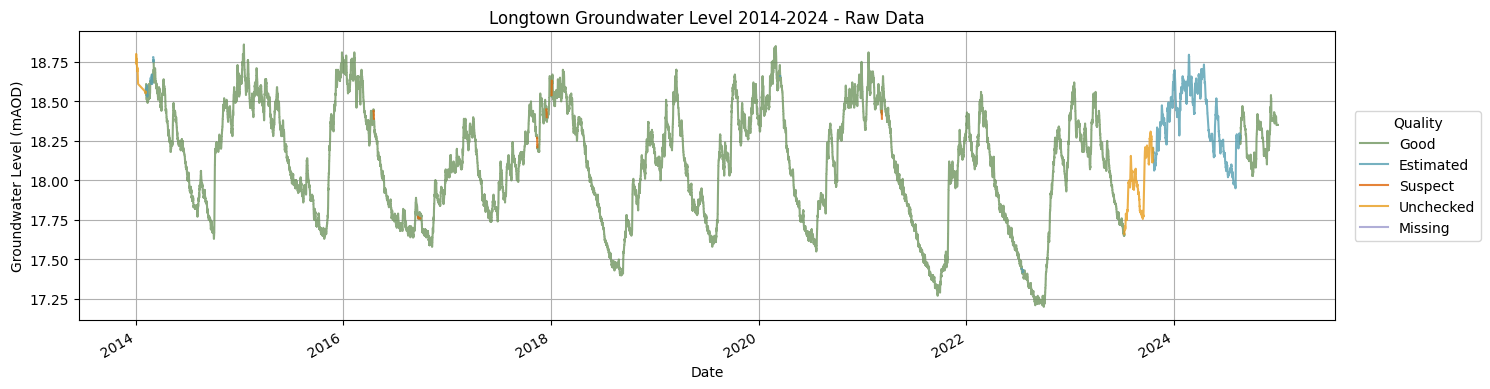

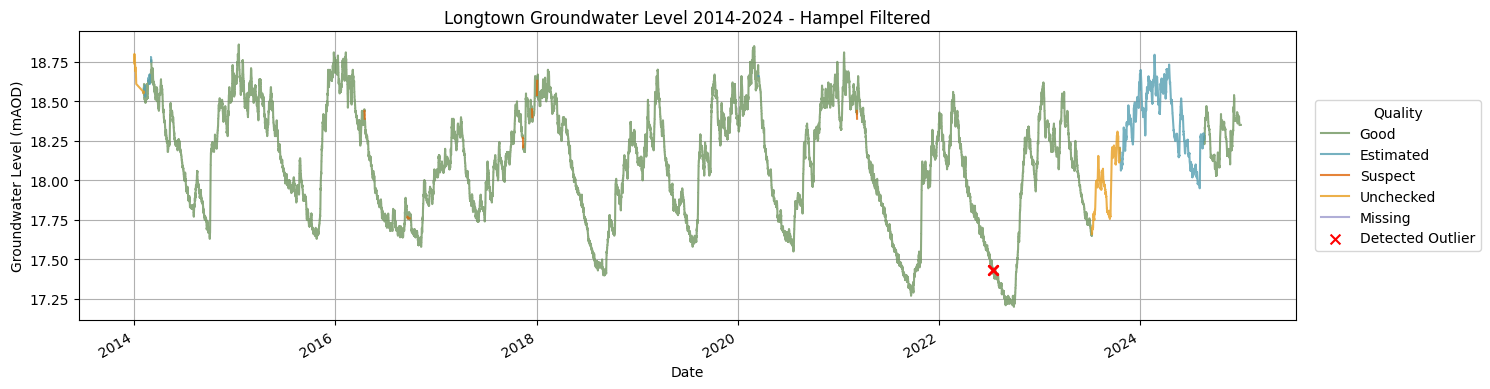

INFO - Processing 2 / 14: Scaleby...

INFO - Station Scaleby: Hard limits 39.54 - 42.73
INFO - Station Scaleby: Identified 1 points outsideIQR-based range and set to NaN.
INFO - Total 267 outliers detected and replaced by Hampel filter in 'Scaleby'.
INFO - Processing Scaleby complete.



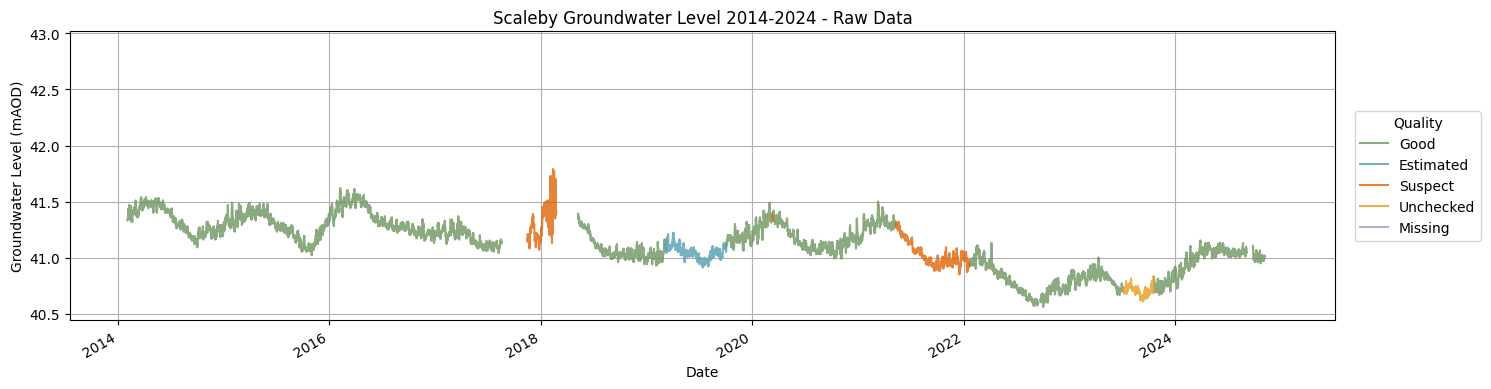

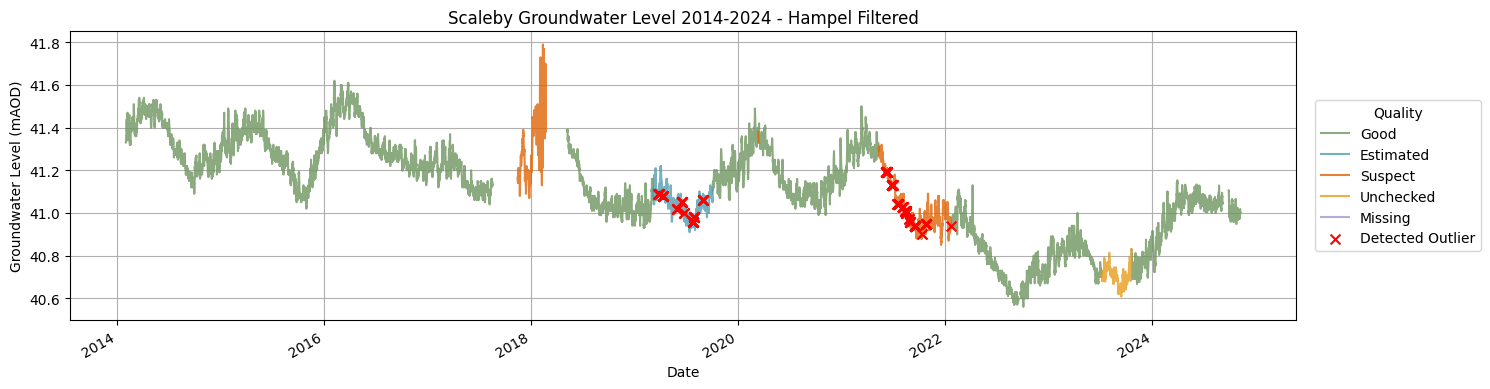

INFO - Processing 3 / 14: Castle_Carrock...

INFO - Station Castle_Carrock: Hard limits 116.12 - 150.00
INFO - Station Castle_Carrock: No points out of range.
INFO - Total 84 outliers detected and replaced by Hampel filter in 'Castle_Carrock'.
INFO - Processing Castle_Carrock complete.



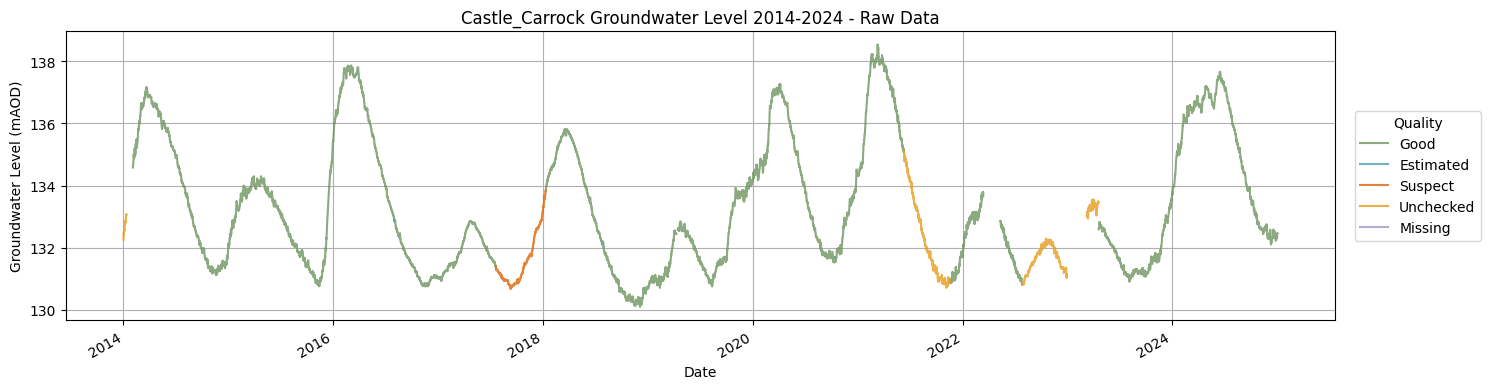

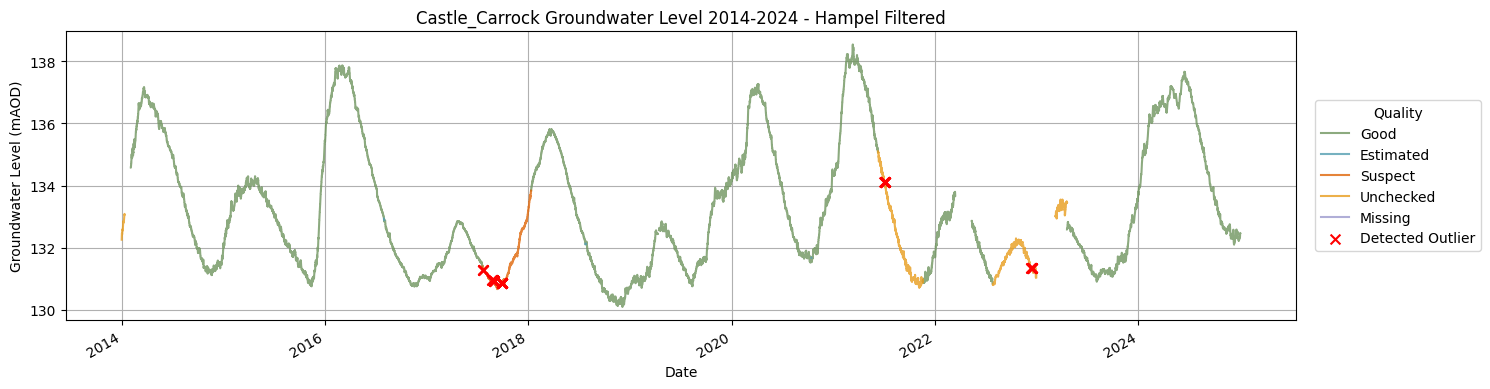

INFO - Processing 4 / 14: Croglin...

INFO - Station Croglin: Hard limits 157.08 - 178.20
INFO - Station Croglin: No points out of range.
INFO - Total 224 outliers detected and replaced by Hampel filter in 'Croglin'.
INFO - Processing Croglin complete.



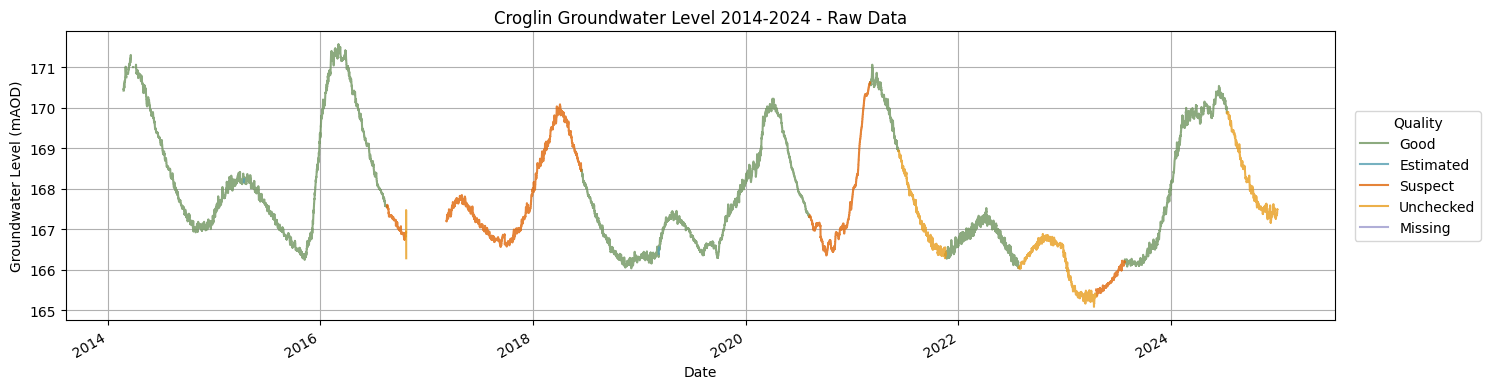

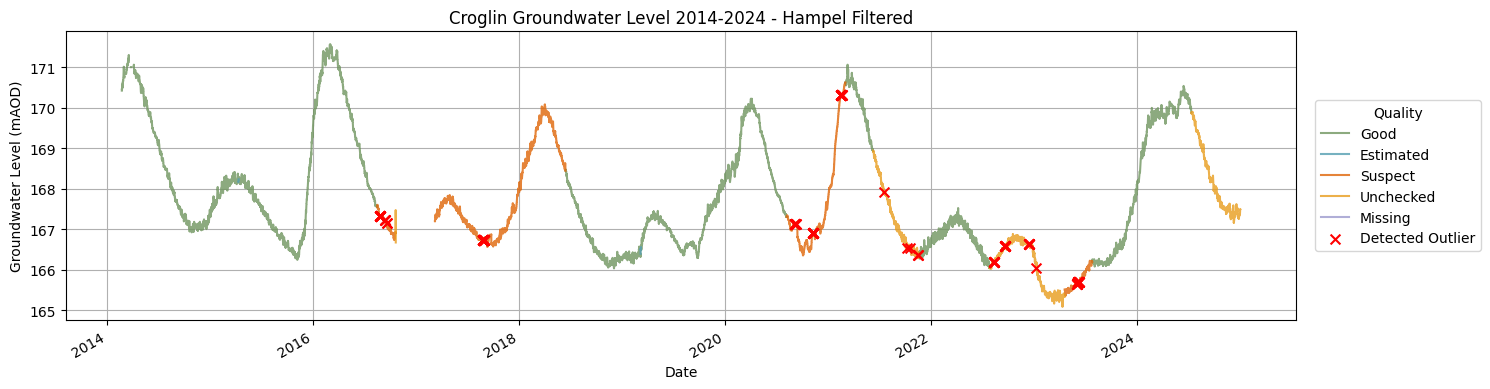

INFO - Processing 5 / 14: Baronwood...

INFO - Station Baronwood: Hard limits 83.36 - 88.33
INFO - Station Baronwood: No points out of range.
INFO - Total 26 outliers detected and replaced by Hampel filter in 'Baronwood'.
INFO - Processing Baronwood complete.



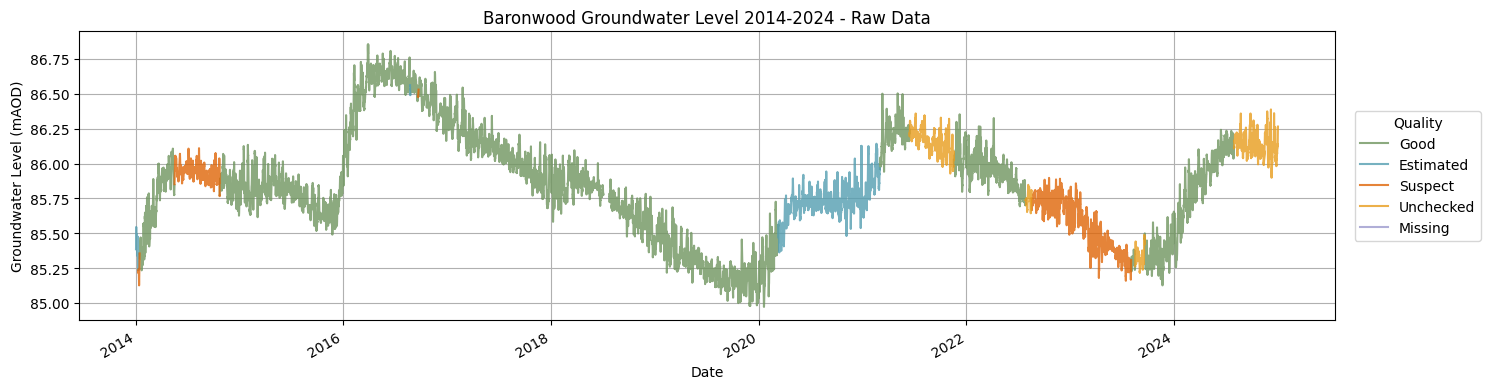

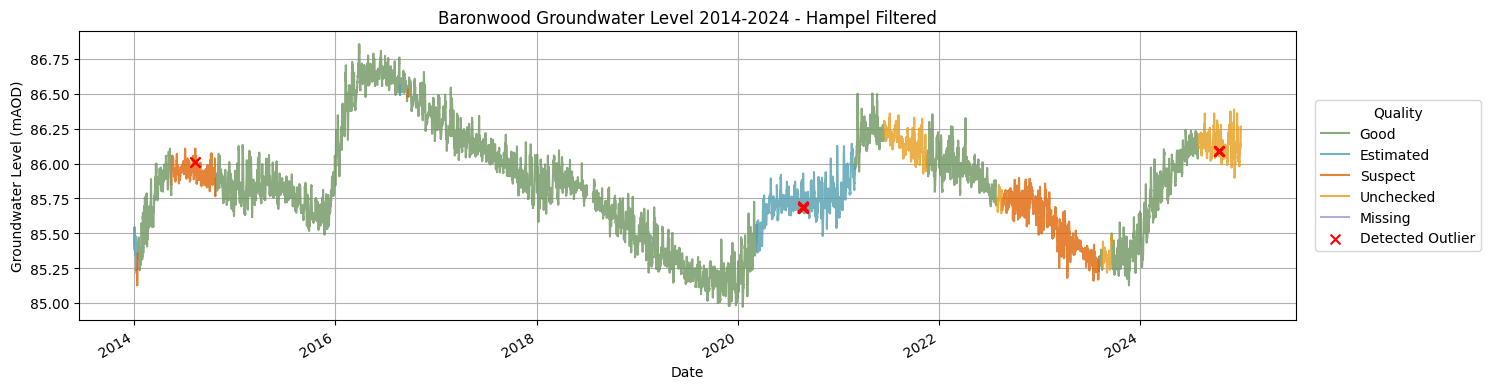

INFO - Processing 6 / 14: Renwick...

INFO - Station Renwick: Hard limits 165.24 - 189.61
INFO - Station Renwick: No points out of range.
INFO - Total 27 outliers detected and replaced by Hampel filter in 'Renwick'.
INFO - Processing Renwick complete.



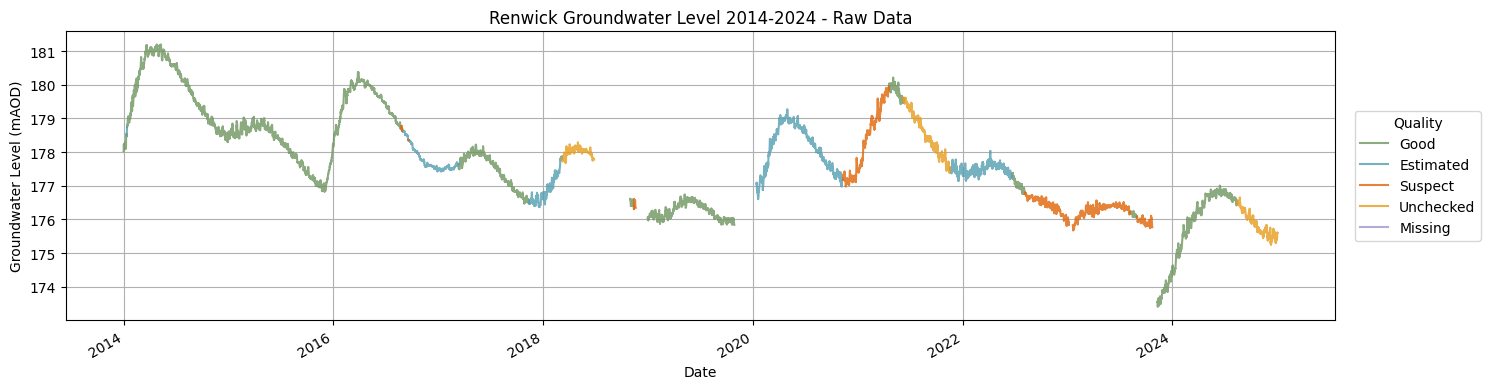

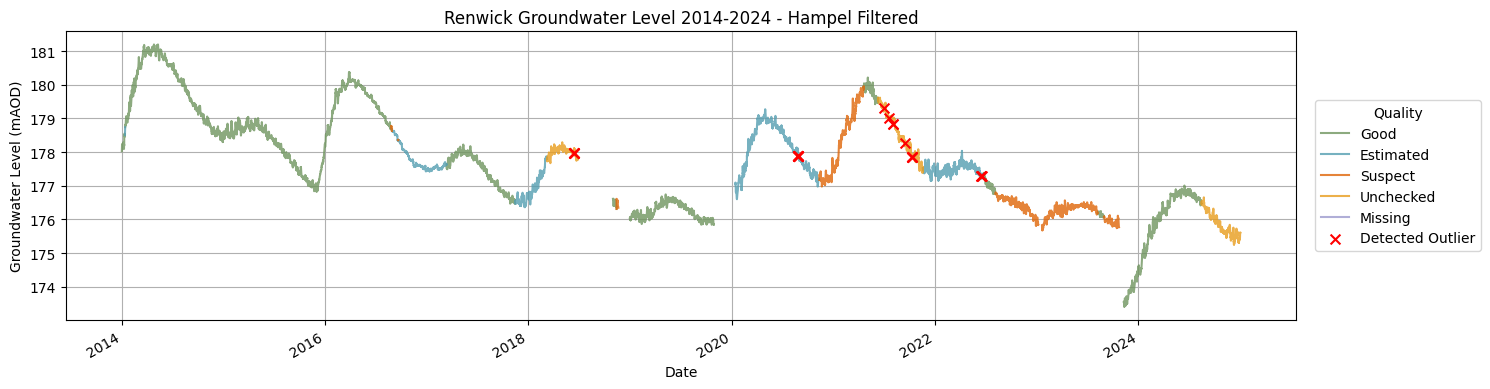

INFO - Processing 7 / 14: East_Brownrigg...

INFO - Station East_Brownrigg: Hard limits 103.90 - 109.59
INFO - Station East_Brownrigg: Identified 46 points outsideIQR-based range and set to NaN.
INFO - Total 19 outliers detected and replaced by Hampel filter in 'East_Brownrigg'.
INFO - Processing East_Brownrigg complete.



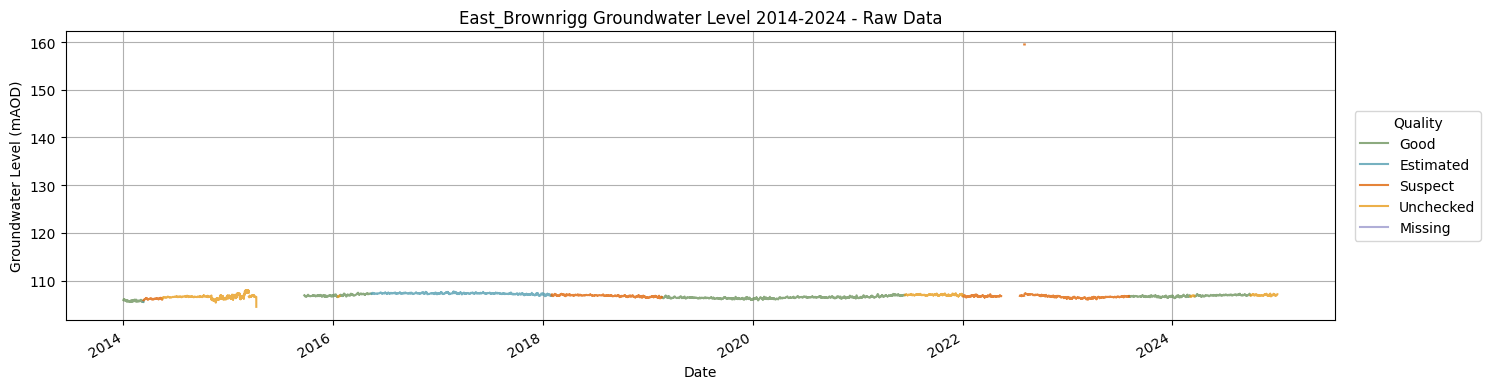

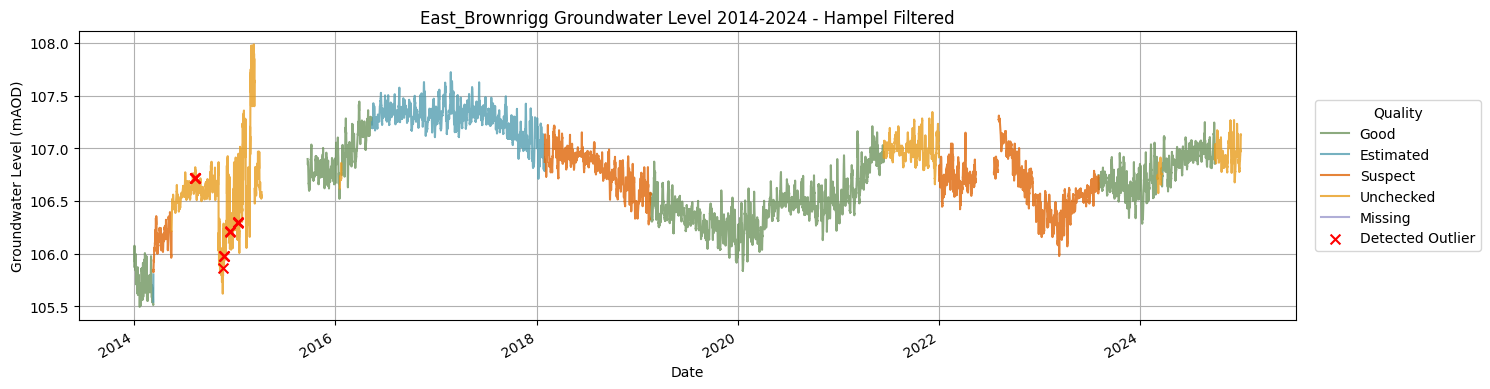

INFO - Processing 8 / 14: Bgs_Ev2...

INFO - Station Bgs_Ev2: Hard limits 85.33 - 89.06
INFO - Station Bgs_Ev2: Identified 1174 points outsideIQR-based range and set to NaN.
INFO - Total 31 outliers detected and replaced by Hampel filter in 'Bgs_Ev2'.
INFO - Processing Bgs_Ev2 complete.



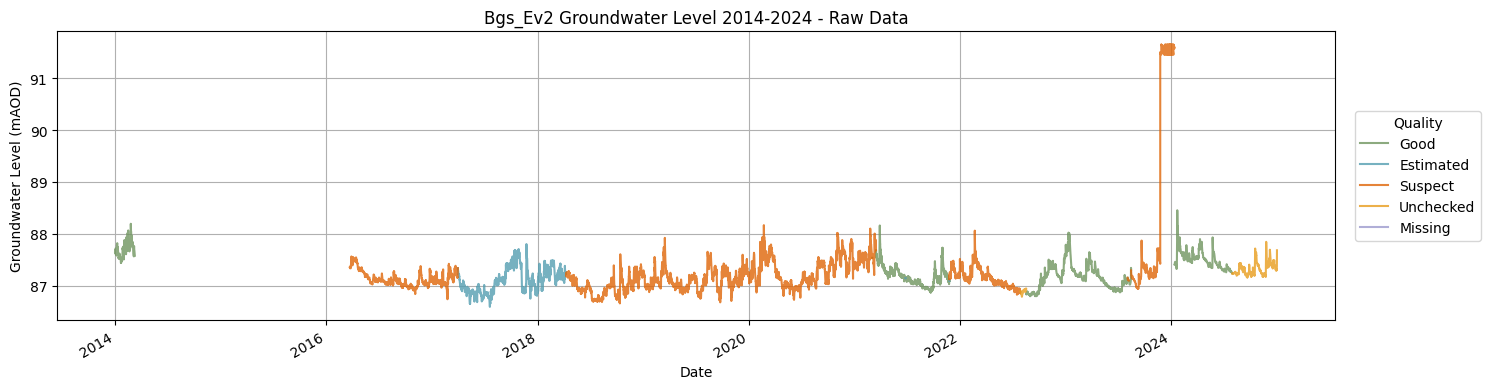

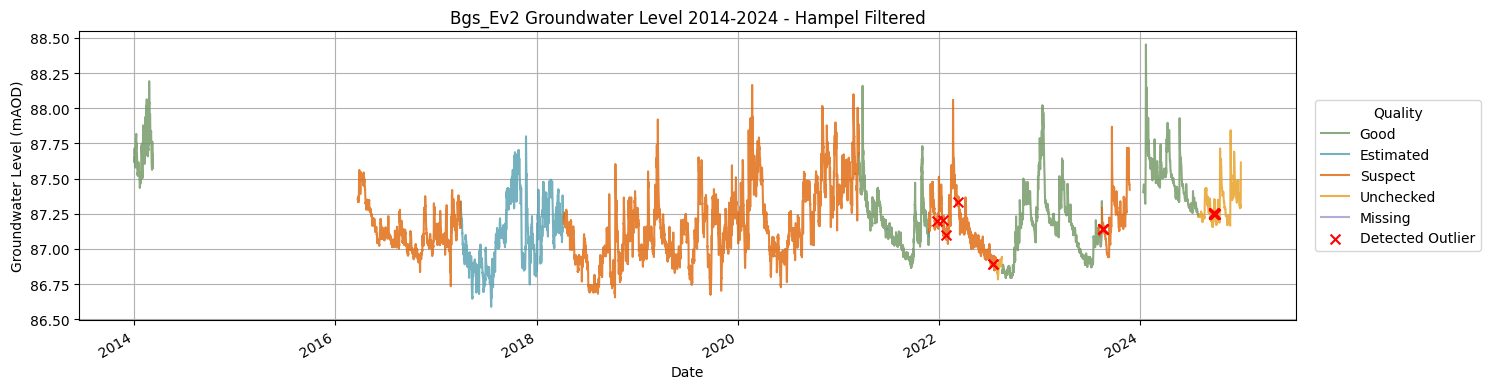

INFO - Processing 9 / 14: Skirwith...

INFO - Station Skirwith: Hard limits 127.49 - 134.00
INFO - Station Skirwith: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Skirwith'.
INFO - Processing Skirwith complete.



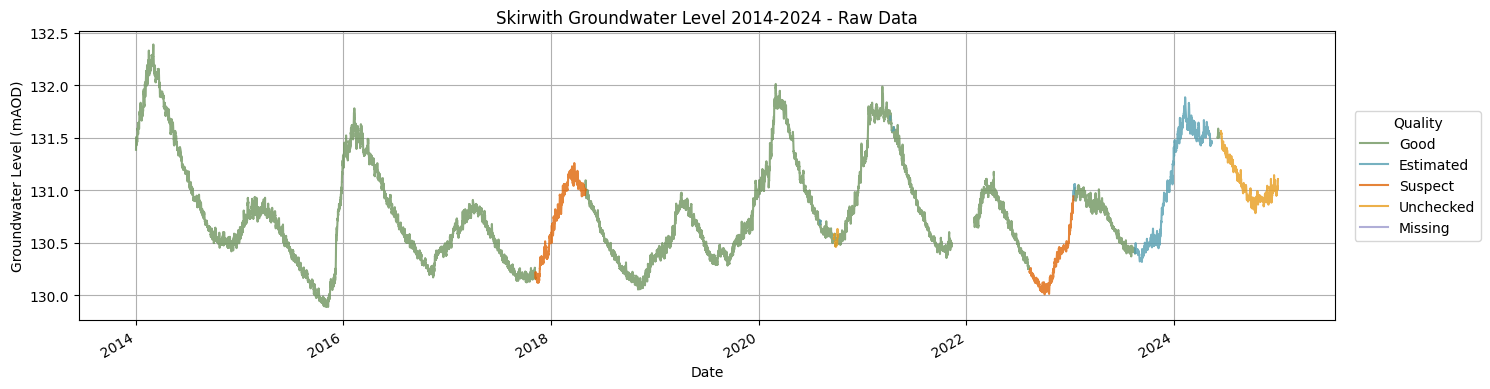

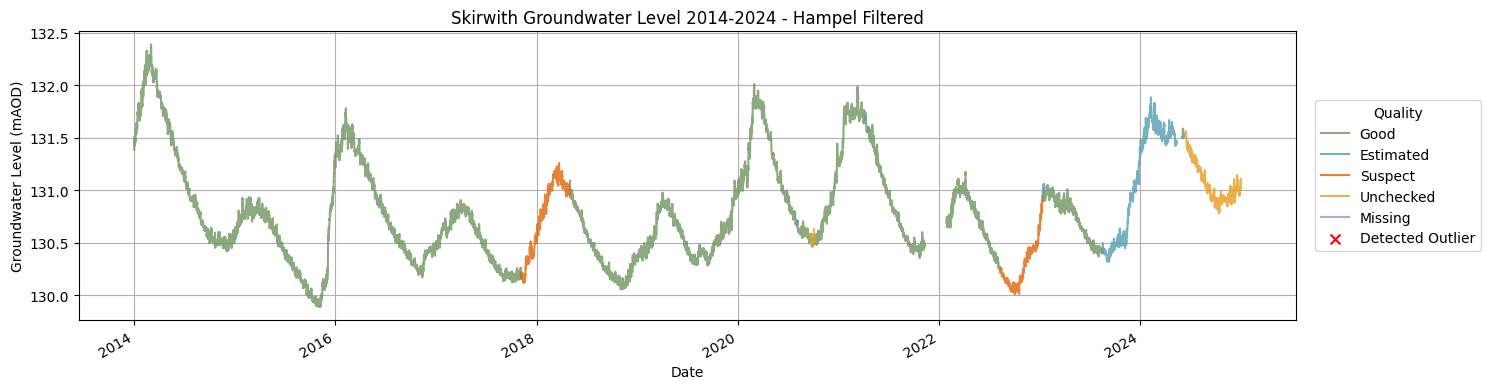

INFO - Processing 10 / 14: Cliburn_Town_Bridge_1...

INFO - Station Cliburn_Town_Bridge_1: Hard limits 109.03 - 111.32
INFO - Station Cliburn_Town_Bridge_1: Identified 49 points outsideIQR-based range and set to NaN.
INFO - Total 2 outliers detected and replaced by Hampel filter in 'Cliburn_Town_Bridge_1'.
INFO - Processing Cliburn_Town_Bridge_1 complete.



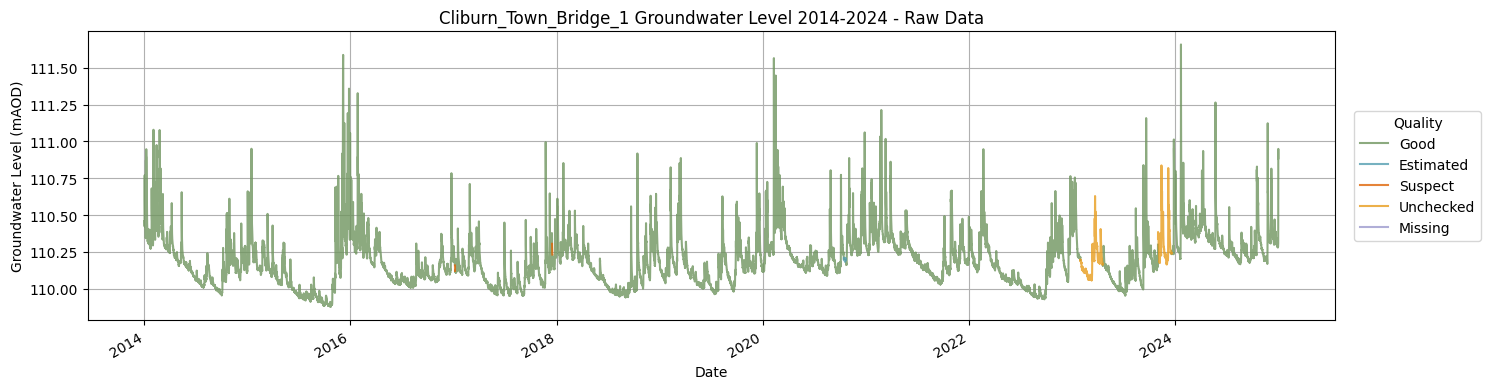

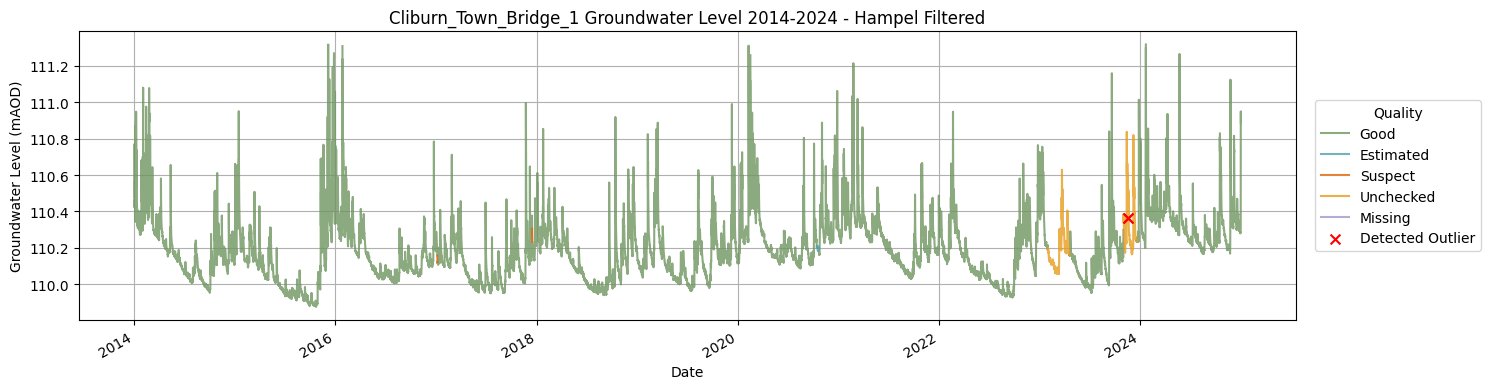

INFO - Processing 11 / 14: Hilton...

INFO - Station Hilton: Hard limits 206.56 - 222.77
INFO - Station Hilton: No points out of range.
INFO - Total 28 outliers detected and replaced by Hampel filter in 'Hilton'.
INFO - Processing Hilton complete.



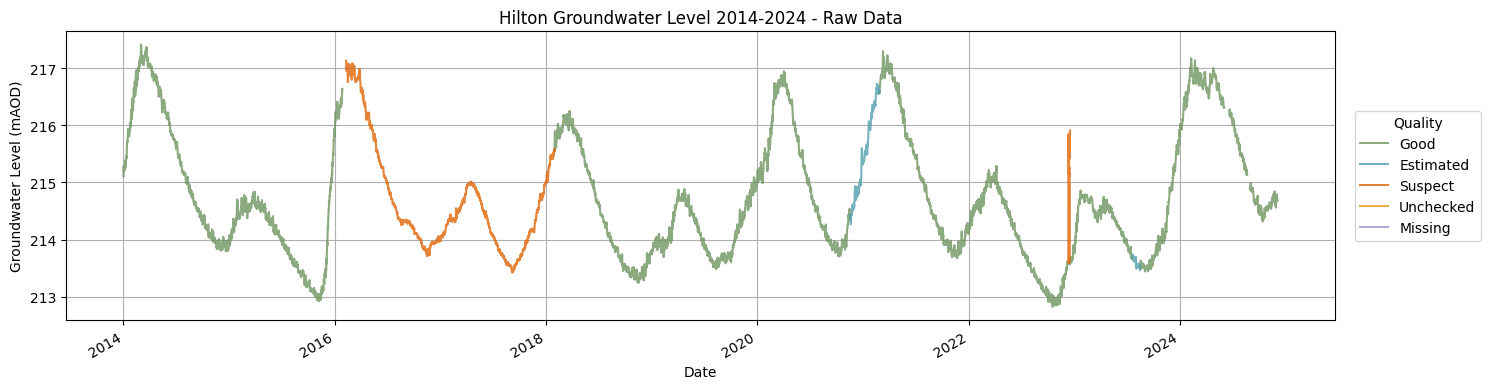

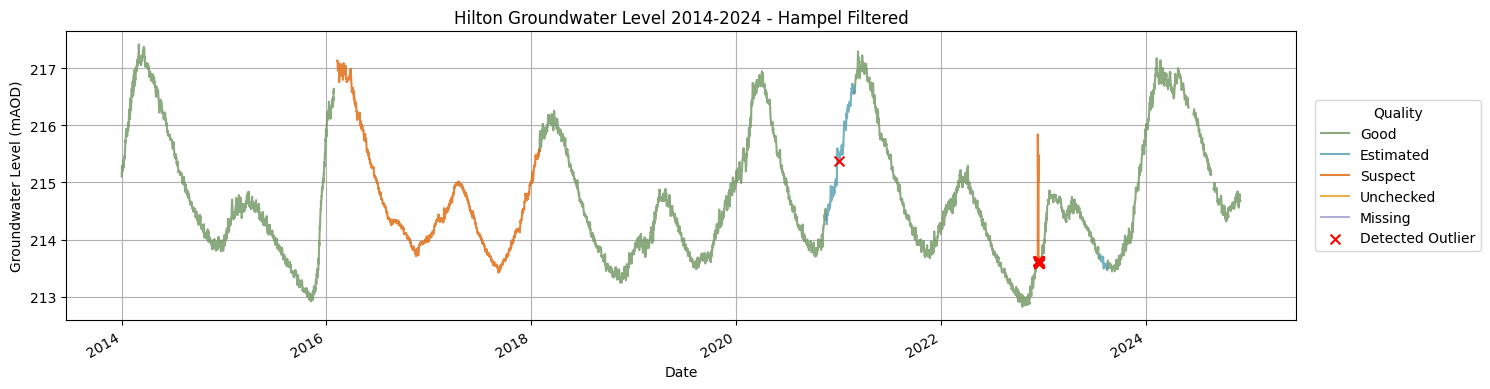

INFO - Processing 12 / 14: Coupland...

INFO - Station Coupland: Hard limits 133.92 - 137.40
INFO - Station Coupland: No points out of range.
INFO - Total 10 outliers detected and replaced by Hampel filter in 'Coupland'.
INFO - Processing Coupland complete.



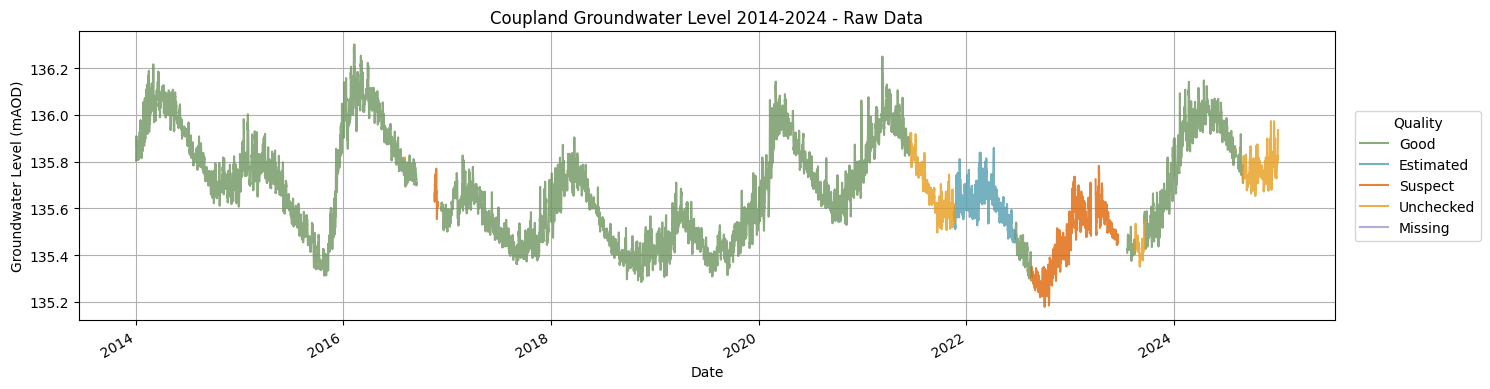

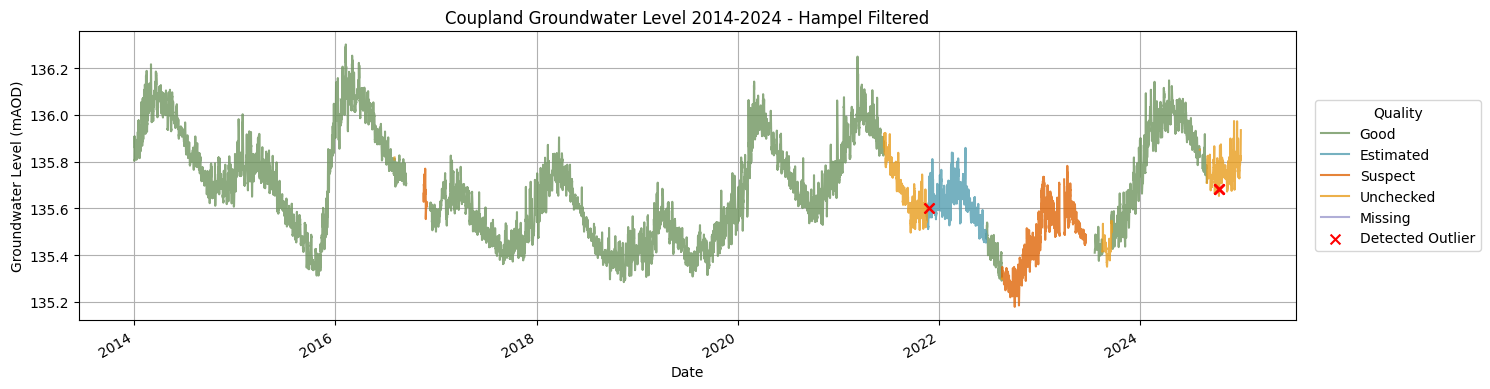

INFO - Processing 13 / 14: Great_Musgrave...

INFO - Station Great_Musgrave: Hard limits 148.78 - 155.59
INFO - Station Great_Musgrave: No points out of range.
INFO - Total 8 outliers detected and replaced by Hampel filter in 'Great_Musgrave'.
INFO - Processing Great_Musgrave complete.



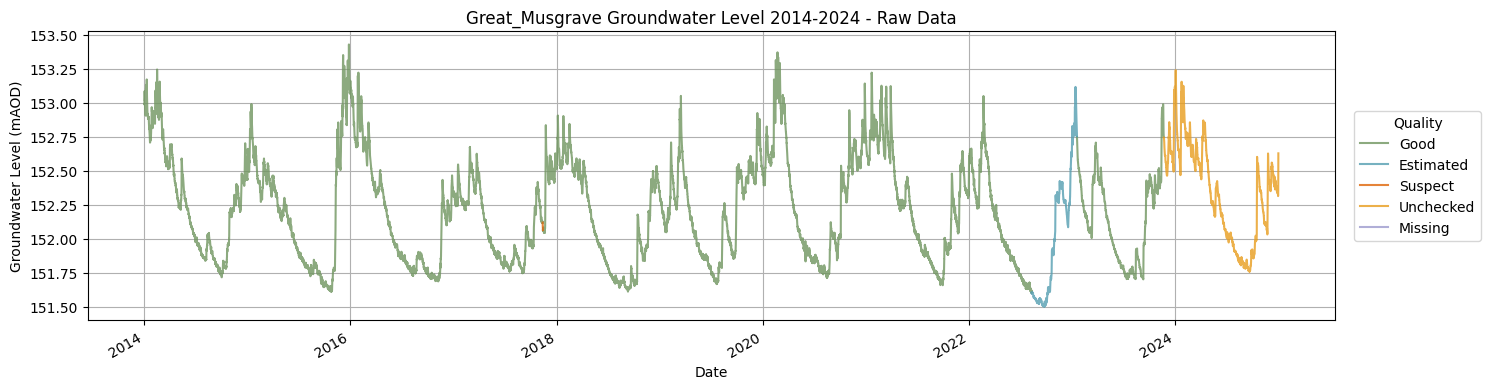

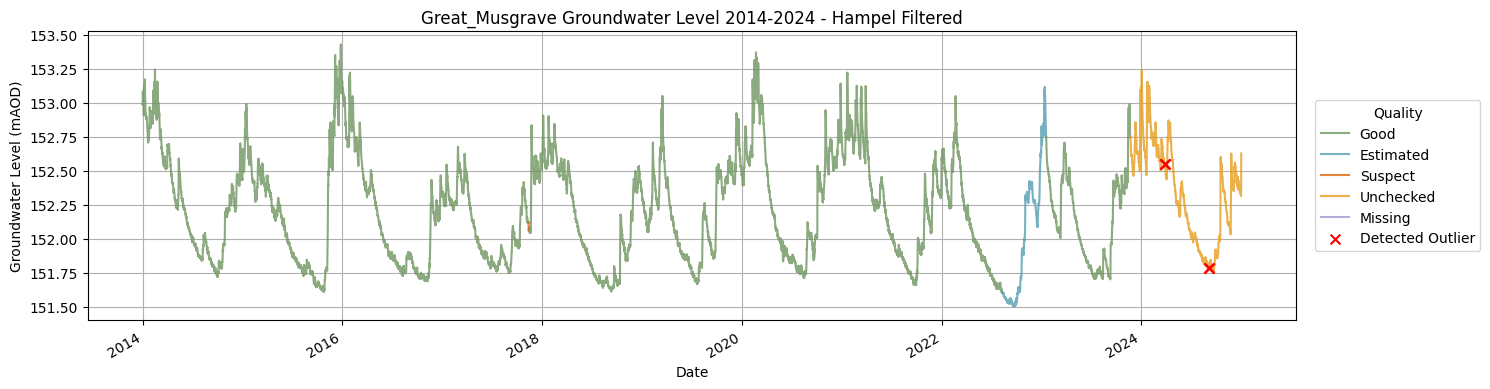

INFO - Processing 14 / 14: East_Curthwaite...

INFO - Station East_Curthwaite: Hard limits 36.94 - 41.40
INFO - Station East_Curthwaite: No points out of range.
INFO - Total 13 outliers detected and replaced by Hampel filter in 'East_Curthwaite'.
INFO - Processing East_Curthwaite complete.



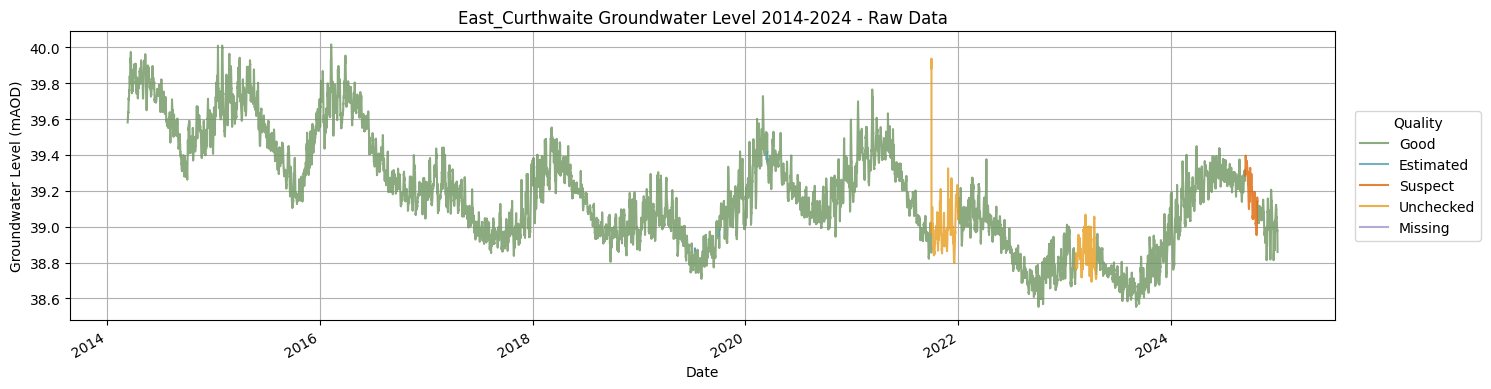

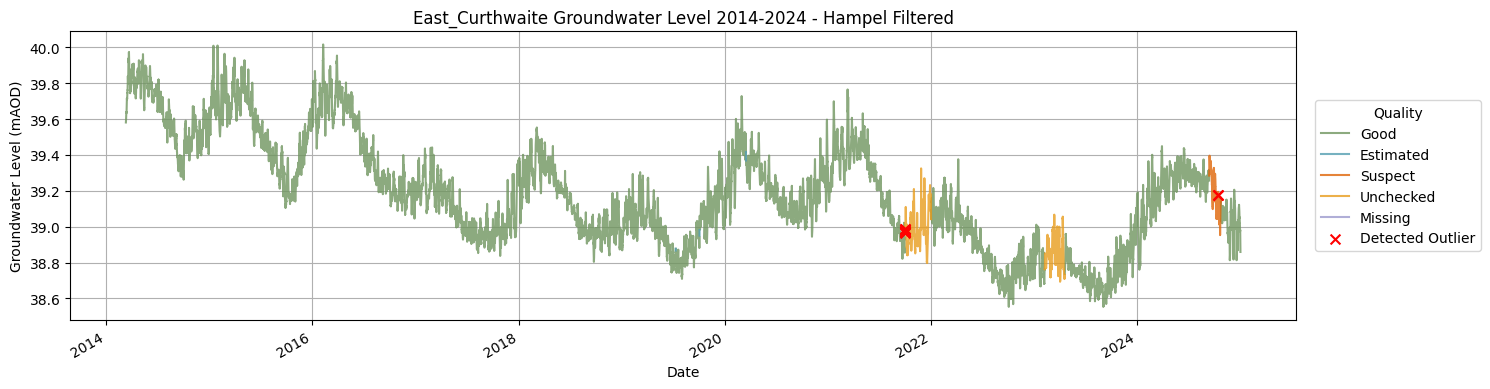

In [ ]:
# run outlier detection and processing
processed_gwl_time_series_dict = outlier_detection(
    gwl_time_series_dict = gwl_time_series_dict,
    output_path = config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
    dpi = config[catchment]["visualisations"]["ts_plots"]["dpi_save"],
    notebook = True,
)

3. Aggregate to daily time steps

4. Interpolate across small gaps in the ts data (define threshold n/o missing time steps for interpolation eligibility) + Add binary interpolation flag column

5. Lagged: Add lagged features (by timestep across 7 days?) + potentially rolling averages (3-day/7-day?)

6. Temporal Encoding: Define sinasoidal features for seasonality (both sine and cosine for performance)